Реализация равномерной схемы крест в лагранжевых координатах

In [598]:
import numpy as np
import matplotlib.pyplot as plt

In [599]:
def z_to_t(z):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    return (2/(3*np.sqrt(Omega_L)) * 1/(h*100*1e5/(R*1e6))
           *np.arcsinh(np.sqrt(Omega_L/(Omega_M*(1 + z)**3)))*3.17*1e-14)

def courant(dt,r,rho,P):
    gamma = 5/3
    c = np.min(np.sqrt(gamma*P[-1,:]/rho[-1,:]))
    dt_new = 0.1*np.min((r[-1,1:]-r[-1,:-1])/c)
    return dt_new*(dt>dt_new) + dt*(dt<dt_new)

In [600]:
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]
M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e7*M_sun
R = 3.0856776*1e18 # [cm] 1pc
kB = 1.38*1e-16 # [эрг * К^-1]
c = 3.*1e10 # [sm/s]
h = 0.674
m_p = 1.67e-24 # Масса протона [g]

T_s_Myr = 3.17*1e-14 #перевод секунд в Myr
M_min = 1e6*M_sun
length = 100
M = np.linspace(M_min,100*M_min,length)
dm = M[1] - M[0]

T_0 = 2.726 # [K] современная температура фотонов
a1 = 1/119
a2 = 1/115

In [601]:
rho = np.zeros((2,length))
r = np.zeros((2,length))
V = np.zeros((2,length))
T = np.zeros((2,length))
e = np.zeros((2,length))
dPhi_dr = np.zeros((2,length))
P = np.zeros((2,length))

начальные данные

In [602]:
z_in = 100
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)

rho[0,:] = H**2/(8/3*np.pi*G)
r[0,:] = (M/(4/3*np.pi*rho[0,:]))**(1/3)
V[0,:] = H*r[0,:]
T[0,:] = T_0 * (1+z_in) * (1 + a1**(-1)*(1+z_in)**(-1)/(1+a2**(3/2)*(1+z_in)**(3/2)))**(-1)
P[0,:] = rho[0,:]*kB*T[0,:]/m_p
e[0,:] = 3/2*P[0,:]/rho[0,:]

dPhi_dr[0,:] = G*M/r[0,:]**2 + G*M_pbh/r[0,:]**2

t = t_in
t_vector = t_in
dt = t_in/100
sim_time = 0

M_accreted = 0
i = 0

while t<t_in*50:
    V[i+1,:-1] = V[i,:-1] - dt*dPhi_dr[i,:-1] + dt/dm*(P[i,:-1]-P[i,1:])*r[i,:-1]**2
    r[i+1,:-1] = r[i,:-1] + dt*V[i+1,:-1]

    # Граничное условие на бесконечности
    V[i+1,-1] = V[i,-1] - dt*dPhi_dr[i,-1]
    r[i+1,-1] = r[i,-1] + dt*V[i+1,-1]

    rho[i+1,:-1] = 3*dm/(r[i+1,1:]**3 - r[i+1,:-1]**3)/(4*np.pi)
    rho[i+1,-1] = rho[i+1,-2]
    e[i+1,:] = (e[i,:]+1/2*P[i,:]*(1/rho[i,:]-1/rho[i+1,:]))/(1-1/3*rho[i+1,:]*(1/rho[i,:]-1/rho[i+1,:]))
    T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
    P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]



    # Переход на следующий слой
    t += dt
    H_new = 2/(3*t)
    # Если первый радиус уходит в - то передвигаем сетку на один вправо (масса в центр по идее добавляется автоматически так как мы сдвигаем сетку по M)
    if r[i+1,0]<0:
        M_accreted += dm                                       # количество аккрецированной массы (считаем что ушедшая в - по r оболочка вошла в ЧД)
        M = np.append(M[1:],M[-1]+dm)
        rho[i+1,:] = np.append(rho[i+1,1:],rho[i+1,-1])        # здесь считаем что на краях плотность не меняется
        r[i+1,:] = np.append(r[i+1,1:], (dm/(4/3*np.pi*rho[i+1,-2]) + r[i+1,-1]**3)**(1/3))
        V[i+1,:] = np.append(V[i+1,1:],(V[i+1,-2] - V[i+1,-1])/(r[i+1,-3]-r[i+1,-2])*(r[i+1,-1]-r[i+1,-2]) + V[i+1,-1])  # здесь индексы r и V смещены тк r обновлен а V еще нет
        e[i+1,:] = np.append(e[i+1,1:], e[i+1,-1])             # аналогично плотности
        T[i+1,:] = 2/3*e[i+1,:]*m_p/kB
        P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]
        print(i+1)
        # print(M_accreted)

    dPhi_dr[i+1,:] = G*M/r[i+1,:]**2 + G*M_pbh/r[i+1,:]**2

    i+=1


    t_vector = np.append(t_vector,t)
    H = np.append(H,H_new)
    V = np.vstack([V,np.zeros(length)])
    r = np.vstack([r,np.zeros(length)])
    rho = np.vstack([rho,np.zeros(length)])
    e = np.vstack([e,np.zeros(length)])
    T = np.vstack([T,np.zeros(length)])
    P = np.vstack([P,np.zeros(length)])
    dPhi_dr = np.vstack([dPhi_dr,np.zeros(length)])

112
1.98847e+39
189
3.97694e+39
265
5.96541e+39
341
7.95388e+39
420
9.94235e+39
500
1.193082e+40
584
1.391929e+40
669
1.590776e+40
758
1.7896230000000002e+40
848
1.9884700000000003e+40
941
2.1873170000000004e+40
1036
2.3861640000000006e+40
1134
2.5850110000000007e+40
1234
2.783858000000001e+40
1336
2.982705000000001e+40
1440
3.181552000000001e+40
1547
3.380399000000001e+40
1655
3.5792460000000013e+40
1766
3.7780930000000015e+40
1879
3.9769400000000016e+40
1993
4.1757870000000017e+40
2110
4.374634000000002e+40
2228
4.573481000000002e+40
2348
4.772328000000002e+40
2470
4.971175000000002e+40
2594
5.170022000000002e+40
2720
5.3688690000000025e+40
2847
5.567716000000003e+40
2976
5.766563000000003e+40
3107
5.965410000000003e+40
3240
6.164257000000003e+40
3374
6.363104000000003e+40
3509
6.561951000000003e+40
3647
6.760798000000003e+40
3785
6.9596450000000035e+40
3926
7.158492000000004e+40
4068
7.357339000000004e+40
4211
7.556186000000004e+40
4356
7.755033000000004e+40
4502
7.953880000000004e+

Отрисовка

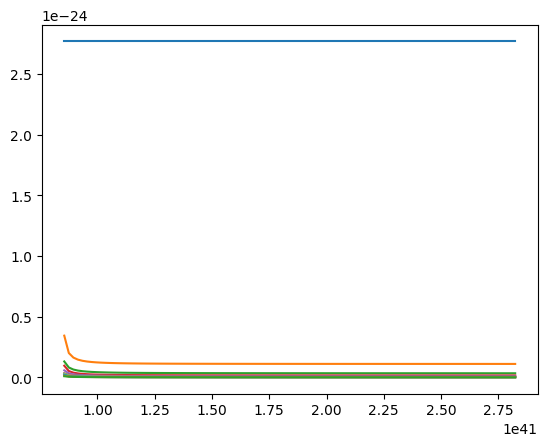

In [603]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 400
for i in range(draw_time_zero, rho.shape[0]-1, draw_time_step):
    ax.plot(M[:], rho[i, :])
plt.show()

In [618]:
M_accreted/M_sun

42000000.00000002

In [605]:
dPhi_dr[848,:]

array([1.69868638e-09, 7.83925246e-10, 5.19463899e-10, 3.97106373e-10,
       3.27454857e-10, 2.82830958e-10, 2.51968395e-10, 2.29450145e-10,
       2.12359097e-10, 1.98989289e-10, 1.88278298e-10, 1.79530836e-10,
       1.72273244e-10, 1.66171959e-10, 1.60985438e-10, 1.56534566e-10,
       1.52683772e-10, 1.49328594e-10, 1.46387267e-10, 1.43794899e-10,
       1.41499340e-10, 1.39458220e-10, 1.37636760e-10, 1.36006156e-10,
       1.34542350e-10, 1.33225099e-10, 1.32037249e-10, 1.30964171e-10,
       1.29993314e-10, 1.29113852e-10, 1.28316400e-10, 1.27592780e-10,
       1.26935838e-10, 1.26339288e-10, 1.25797586e-10, 1.25305822e-10,
       1.24859637e-10, 1.24455144e-10, 1.24088869e-10, 1.23757700e-10,
       1.23458835e-10, 1.23189752e-10, 1.22948171e-10, 1.22732027e-10,
       1.22539446e-10, 1.22368723e-10, 1.22218306e-10, 1.22086775e-10,
       1.21972832e-10, 1.21875288e-10, 1.21793051e-10, 1.21725116e-10,
       1.21670559e-10, 1.21628527e-10, 1.21598233e-10, 1.21578946e-10,
      

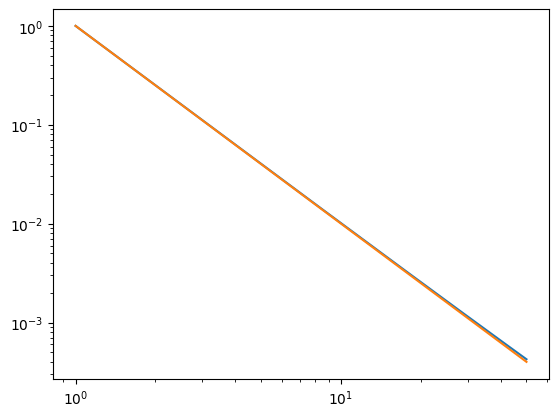

In [606]:
fig, ax = plt.subplots()
hh=1
ax.plot(t_vector[:-hh]/t_vector[0], rho[:-hh-1, -1]/rho[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-2)

In [607]:
rho[800:900,-3]/rho[0,-3]

array([0.01248151, 0.01245398, 0.01242654, 0.0123992 , 0.01237194,
       0.01234477, 0.0123177 , 0.01229071, 0.01226382, 0.01223701,
       0.01221029, 0.01218366, 0.01215711, 0.01213065, 0.01210428,
       0.012078  , 0.0120518 , 0.01202569, 0.01199966, 0.01197372,
       0.01194786, 0.01192209, 0.0118964 , 0.01187079, 0.01184527,
       0.01181983, 0.01179447, 0.0117692 , 0.011744  , 0.01171889,
       0.01169386, 0.0116689 , 0.01164403, 0.01161924, 0.01159453,
       0.0115699 , 0.01154534, 0.01152087, 0.01149647, 0.01147215,
       0.01144791, 0.01142375, 0.01139966, 0.01137565, 0.01135171,
       0.01132786, 0.01130407, 0.01128037, 0.01125543, 0.01123186,
       0.01120837, 0.01118495, 0.0111616 , 0.01113833, 0.01111513,
       0.011092  , 0.01106894, 0.01104596, 0.01102305, 0.01100021,
       0.01097744, 0.01095475, 0.01093212, 0.01090957, 0.01088708,
       0.01086467, 0.01084232, 0.01082004, 0.01079784, 0.0107757 ,
       0.01075363, 0.01073163, 0.01070969, 0.01068782, 0.01066

In [608]:
rho.shape

(4903, 100)

In [609]:
rho[849,-3]/rho[0,-3]

0.011231860825449622

In [610]:
M

array([8.5504210e+40, 8.7492680e+40, 8.9481150e+40, 9.1469620e+40,
       9.3458090e+40, 9.5446560e+40, 9.7435030e+40, 9.9423500e+40,
       1.0141197e+41, 1.0340044e+41, 1.0538891e+41, 1.0737738e+41,
       1.0936585e+41, 1.1135432e+41, 1.1334279e+41, 1.1533126e+41,
       1.1731973e+41, 1.1930820e+41, 1.2129667e+41, 1.2328514e+41,
       1.2527361e+41, 1.2726208e+41, 1.2925055e+41, 1.3123902e+41,
       1.3322749e+41, 1.3521596e+41, 1.3720443e+41, 1.3919290e+41,
       1.4118137e+41, 1.4316984e+41, 1.4515831e+41, 1.4714678e+41,
       1.4913525e+41, 1.5112372e+41, 1.5311219e+41, 1.5510066e+41,
       1.5708913e+41, 1.5907760e+41, 1.6106607e+41, 1.6305454e+41,
       1.6504301e+41, 1.6703148e+41, 1.6901995e+41, 1.7100842e+41,
       1.7299689e+41, 1.7498536e+41, 1.7697383e+41, 1.7896230e+41,
       1.8095077e+41, 1.8293924e+41, 1.8492771e+41, 1.8691618e+41,
       1.8890465e+41, 1.9089312e+41, 1.9288159e+41, 1.9487006e+41,
       1.9685853e+41, 1.9884700e+41, 2.0083547e+41, 2.0282394e

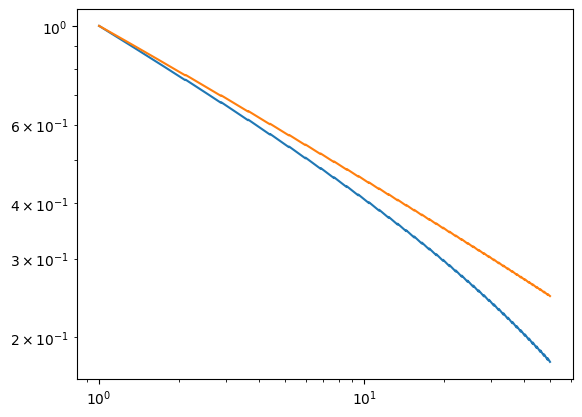

In [611]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, -1]/V[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],H*r[:-1,-1]/V[0,-1])

In [612]:
rho[-2,:]

array([1.68338698e-26, 8.35551257e-27, 5.84890932e-27, 4.63391317e-27,
       3.91266109e-27, 3.43347736e-27, 3.09134854e-27, 2.83452786e-27,
       2.63450331e-27, 2.47424603e-27, 2.34294453e-27, 2.23339726e-27,
       2.14061783e-27, 2.06104170e-27, 1.99205154e-27, 1.93168130e-27,
       1.87842486e-27, 1.83110853e-27, 1.78880390e-27, 1.75076672e-27,
       1.71639329e-27, 1.68518867e-27, 1.65674319e-27, 1.63071480e-27,
       1.60681566e-27, 1.58480174e-27, 1.56446482e-27, 1.54562613e-27,
       1.52813131e-27, 1.51184639e-27, 1.49665452e-27, 1.48245330e-27,
       1.46915267e-27, 1.45667302e-27, 1.44494382e-27, 1.43390227e-27,
       1.42349232e-27, 1.41366380e-27, 1.40437161e-27, 1.39557518e-27,
       1.38723783e-27, 1.37932640e-27, 1.37181078e-27, 1.36466346e-27,
       1.35786024e-27, 1.35137445e-27, 1.34520294e-27, 1.33925437e-27,
       1.33377311e-27, 1.32789367e-27, 1.32403555e-27, 1.31604269e-27,
       1.31730420e-27, 1.30287113e-27, 1.31104858e-27, 1.29470383e-27,
      

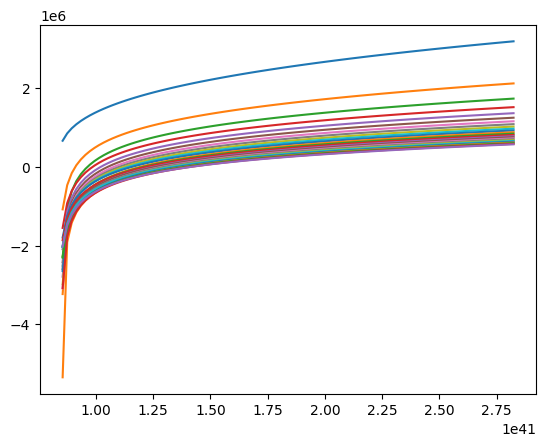

In [613]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 200
for i in range(draw_time_zero, V.shape[0]-1, draw_time_step):
    ax.plot(M[:], V[i+1, :])
plt.show()

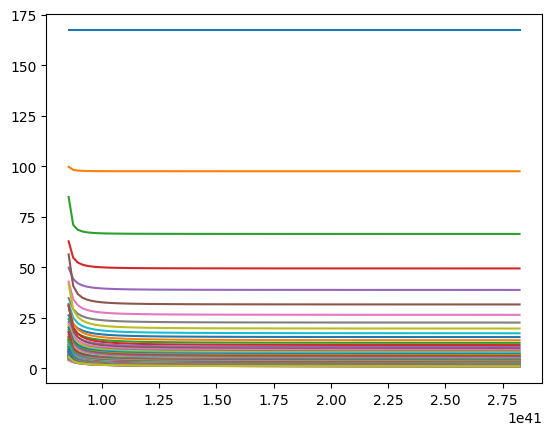

In [614]:
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, T.shape[0]-1, draw_time_step):
    ax.plot(M[:], T[i, :])
plt.show()

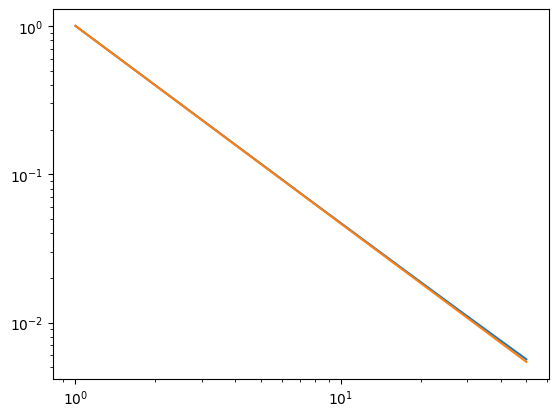

In [615]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], T[:-1, -1]/T[0, -1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-(4/3))

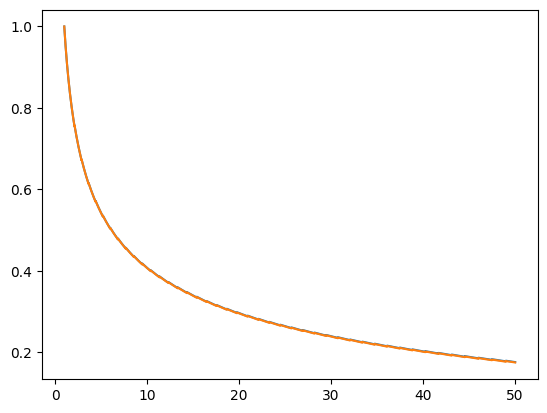

In [616]:
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], V[:-1, -1]/V[0, -1])
ax.plot(t_vector/t_vector[0], V[:-1, -2]/V[0, -2])